## Dlib-eos (Supports multiple faces)
#### Steps:
 * Load image and extract facial landmarks using dlib.
 * Fit a face mesh (we'll be using Surrey Face Model) to the extracted landmarks using eos.
 * Render the mesh as 2d points on the image.

In [1]:
import numpy as np
import dlib
import eos
from imageio import imread

In [2]:
# for drawing on jupyter
from io import BytesIO
import PIL.Image
import IPython.display
from skimage.draw import circle

In [3]:
# drawing functions
def show_img(a, fmt='png'):
    a = np.uint8(np.clip(a, 0, 255))
    data = BytesIO()
    PIL.Image.fromarray(a).save(data, fmt)
    IPython.display.display(IPython.display.Image(data=data.getvalue()))
    
def draw_circle(canvas, x, y, r=2, color=(255,255,255)):
    rr,cc = circle(x,y,r,shape=canvas.shape)
    canvas[rr,cc] = color

# get viewport matrix
def viewport_matrix(w,h):
    viewport = np.array([0,h,w,-h])
    
    # scale
    S = np.identity(4,dtype=np.float32)
    S[0][0] *= viewport[2]/2
    S[1][1] *= viewport[3]/2
    S[2][2] *= 0.5
    
    # translate
    T = np.identity(4,dtype=np.float32)
    T[3][0] = viewport[0] + (viewport[2]/2)
    T[3][1] = viewport[1] + (viewport[3]/2)
    T[3][2] = 0.5
    return S@T

In [17]:
import cv2

In [73]:
# load detector,shape predictor and image
detector = dlib.get_frontal_face_detector()
shape_predictor = dlib.shape_predictor('res/68.dat')
img = cv2.imread('image_0010.png')
#img = cv2.cvtColor(img, cv2.)
# get bounding box and facial landmarks
boxes = detector(img)
lp = []
for box in boxes:
    shape = shape_predictor(img, box)
    index = 1
    landmarks = []
    for i in range(shape.num_parts):
        landmarks.append(eos.core.Landmark(str(index),[shape.part(i).x, shape.part(i).y]))
        index +=1
    lp.append(landmarks)

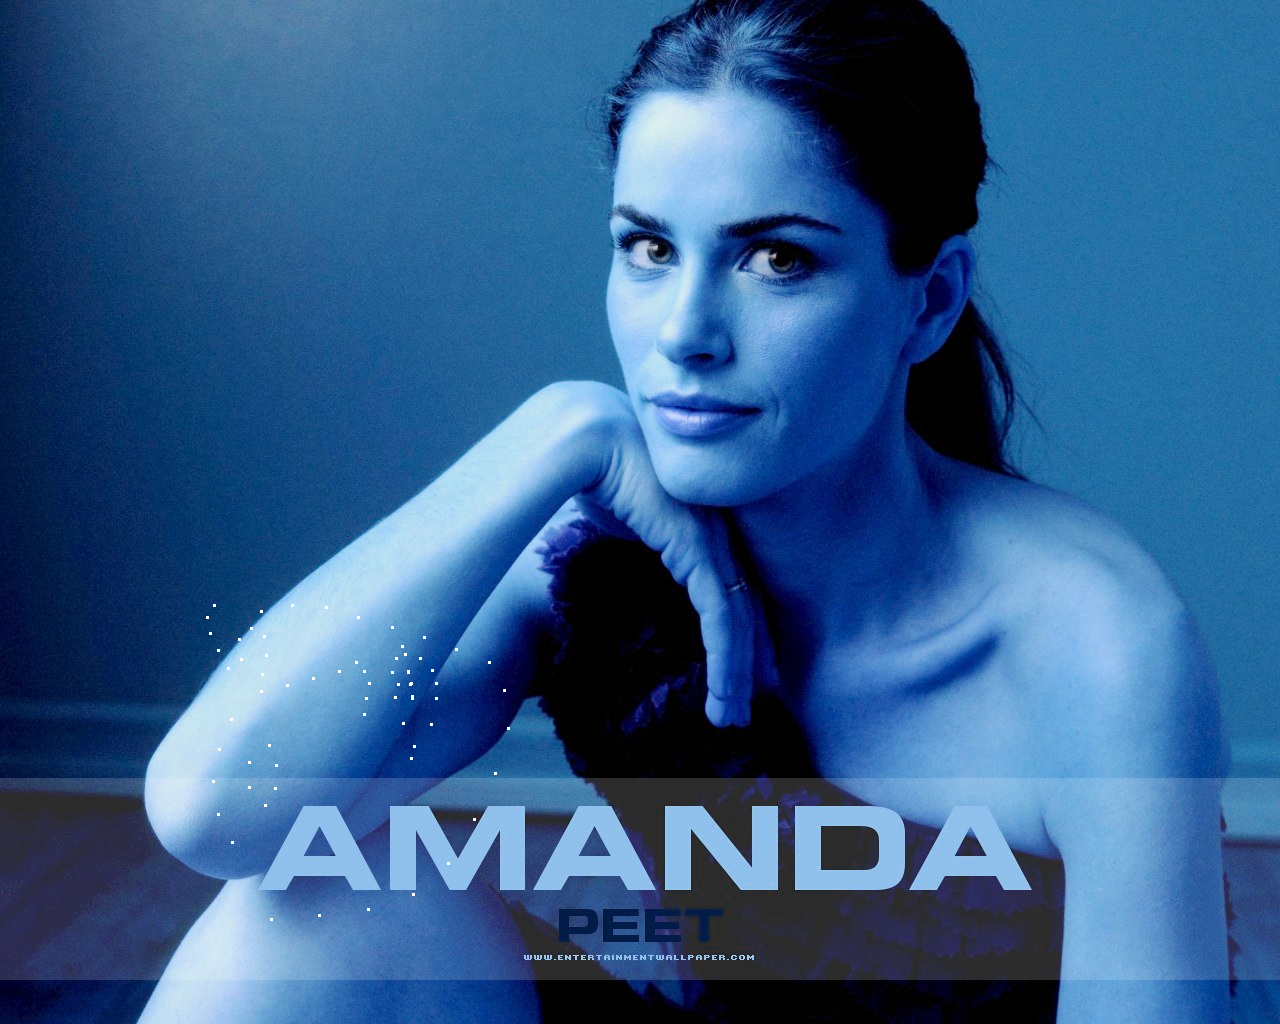

In [74]:
# rendering image with 68 landmarks (for debugging)
canvas = img.copy()
for landmarks in lp:
    for point in landmarks: draw_circle(canvas, point.coordinates[0],point.coordinates[1])
show_img(canvas)

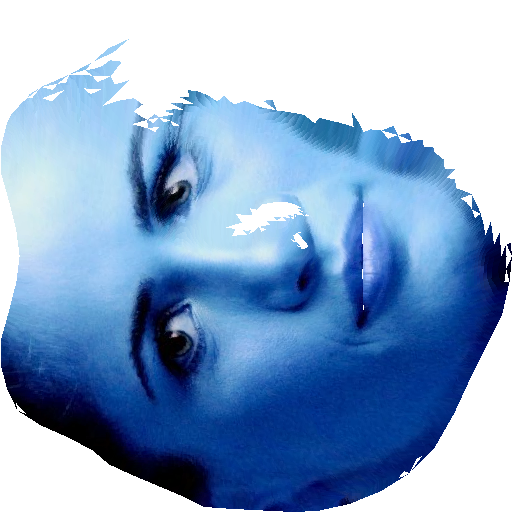

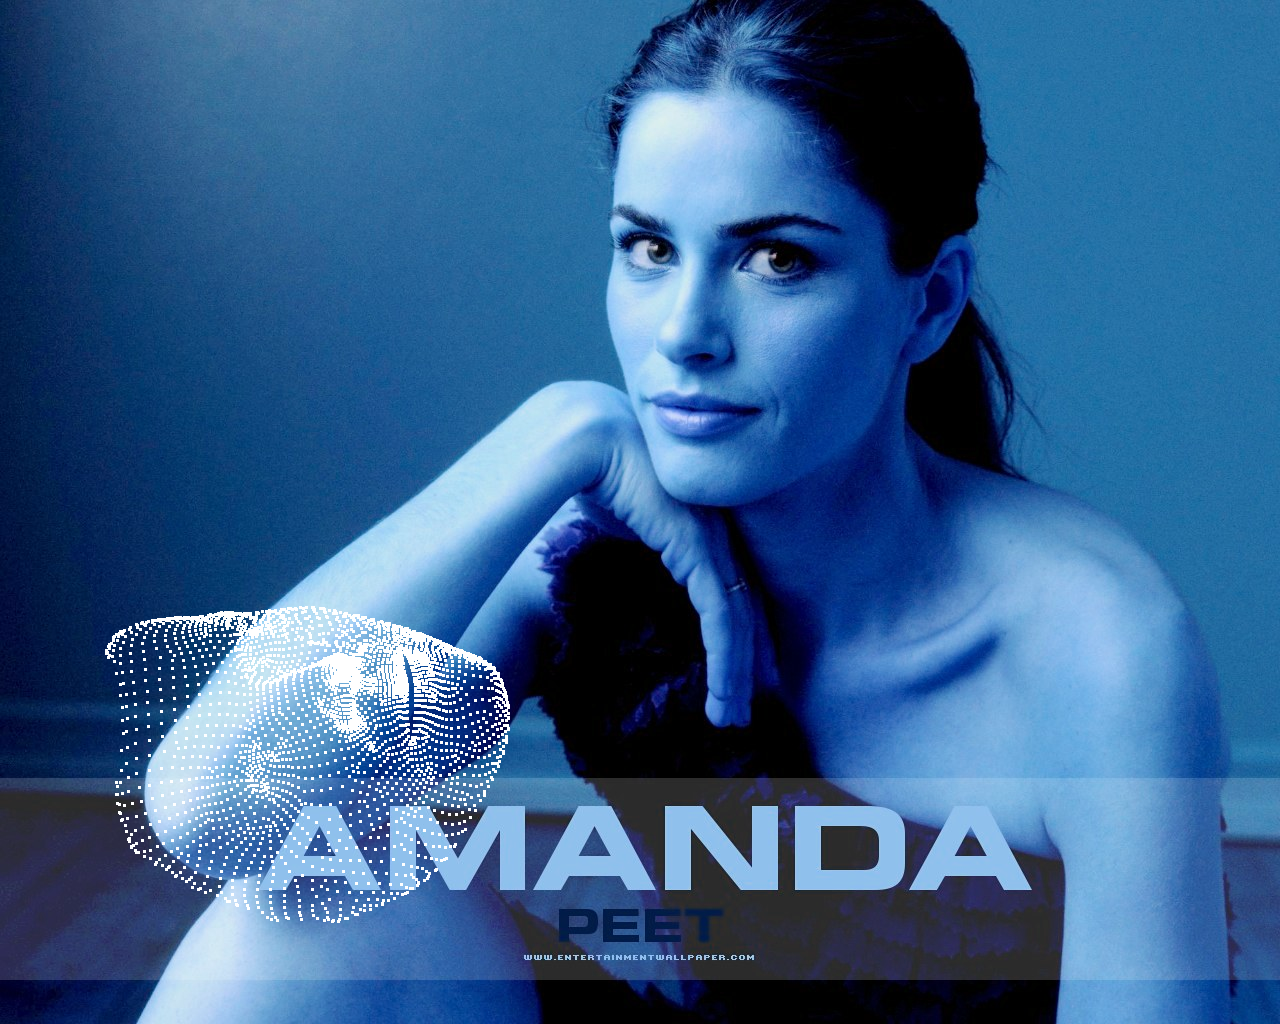

In [75]:
model = eos.morphablemodel.load_model("res/sfm_shape_3448.bin")
blendshapes = eos.morphablemodel.load_blendshapes("res/expression_blendshapes_3448.bin")
morphablemodel_with_expressions = eos.morphablemodel.MorphableModel(
    model.get_shape_model(), 
    blendshapes,
    color_model=eos.morphablemodel.PcaModel(),
    vertex_definitions=None,
    texture_coordinates=model.get_texture_coordinates()
)
landmark_mapper = eos.core.LandmarkMapper('res/ibug_to_sfm.txt')
edge_topology = eos.morphablemodel.load_edge_topology('res/sfm_3448_edge_topology.json')
contour_landmarks = eos.fitting.ContourLandmarks.load('res/ibug_to_sfm.txt')
model_contour = eos.fitting.ModelContour.load('res/sfm_model_contours.json')

h,w = img.shape[:2]
vm = viewport_matrix(w,h)
landmark_ids = list(map(str, range(1, 69)))
canvas = img.copy()
for landmarks in lp:
    mesh, pose, shape_coeffs, blendshape_coeffs = eos.fitting.fit_shape_and_pose(
        morphablemodel_with_expressions,
        landmarks, landmark_mapper, w, h, edge_topology, 
        contour_landmarks,model_contour)
    p = pose.get_projection()
    mv = pose.get_modelview()
    fm = vm@p@mv
    for i in mesh.vertices:
        tmp = fm@np.append(i,1)
        # disregard z and draw 2d pt
        x,y = (int(w/2+tmp[0]),int(h/2+tmp[1]))
        draw_circle(canvas,x,y)
    isomap = eos.render.extract_texture(mesh, pose, canvas)
    show_img(isomap)

# display result
show_img(canvas)

In [70]:
import cv2
image = cv2.imread("image_0010.png")
isomap = eos.render.extract_texture(mesh, pose, image)

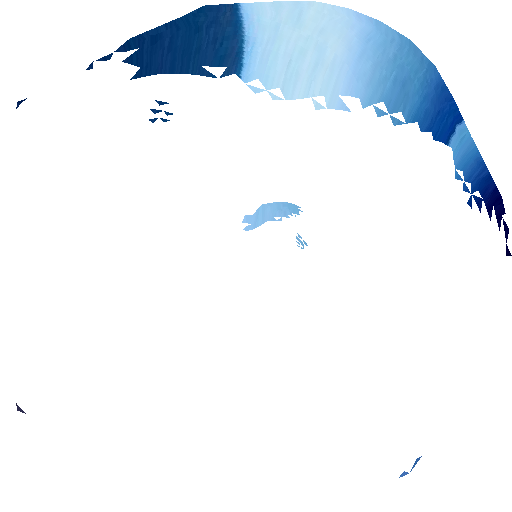

NameError: name 'landmakrs' is not defined

In [56]:
show_img(isomap)

In [71]:
print(landmarks)

[<eos.core.Landmark [name=1, [x=261.000000, y=611.000000]]>, <eos.core.Landmark [name=2, [x=292.000000, y=605.000000]]>, <eos.core.Landmark [name=3, [x=326.000000, y=607.000000]]>, <eos.core.Landmark [name=4, [x=358.000000, y=617.000000]]>, <eos.core.Landmark [name=5, [x=392.000000, y=627.000000]]>, <eos.core.Landmark [name=6, [x=424.000000, y=637.000000]]>, <eos.core.Landmark [name=7, [x=456.000000, y=649.000000]]>, <eos.core.Landmark [name=8, [x=489.000000, y=662.000000]]>, <eos.core.Landmark [name=9, [x=504.000000, y=690.000000]]>, <eos.core.Landmark [name=10, [x=508.000000, y=728.000000]]>, <eos.core.Landmark [name=11, [x=495.000000, y=773.000000]]>, <eos.core.Landmark [name=12, [x=474.000000, y=819.000000]]>, <eos.core.Landmark [name=13, [x=448.000000, y=863.000000]]>, <eos.core.Landmark [name=14, [x=413.000000, y=894.000000]]>, <eos.core.Landmark [name=15, [x=368.000000, y=909.000000]]>, <eos.core.Landmark [name=16, [x=319.000000, y=915.000000]]>, <eos.core.Landmark [name=17, [x=

In [72]:
def read_pts(filename):
    """A helper function to read the 68 ibug landmarks from a .pts file."""
    lines = open(filename).read().splitlines()
    lines = lines[3:71]

    landmarks = []
    ibug_index = 1  # count from 1 to 68 for all ibug landmarks
    for l in lines:
        coords = l.split()
        landmarks.append(eos.core.Landmark(str(ibug_index), [float(coords[0]), float(coords[1])]))
        ibug_index = ibug_index + 1

    return landmarks
landmarks = read_pts('res/image_0010.pts')
print(landmarks)


[<eos.core.Landmark [name=1, [x=611.284180, y=272.773926]]>, <eos.core.Landmark [name=2, [x=607.899780, y=304.319122]]>, <eos.core.Landmark [name=3, [x=613.094666, y=339.255585]]>, <eos.core.Landmark [name=4, [x=622.808899, y=372.005493]]>, <eos.core.Landmark [name=5, [x=632.669434, y=404.678833]]>, <eos.core.Landmark [name=6, [x=643.511780, y=432.387054]]>, <eos.core.Landmark [name=7, [x=651.944702, y=460.095306]]>, <eos.core.Landmark [name=8, [x=665.273071, y=490.435791]]>, <eos.core.Landmark [name=9, [x=695.836426, y=505.268311]]>, <eos.core.Landmark [name=10, [x=732.882874, y=507.601135]]>, <eos.core.Landmark [name=11, [x=771.140930, y=496.682190]]>, <eos.core.Landmark [name=12, [x=814.580017, y=468.528229]]>, <eos.core.Landmark [name=13, [x=852.378540, y=442.776794]]>, <eos.core.Landmark [name=14, [x=879.780396, y=411.071472]]>, <eos.core.Landmark [name=15, [x=894.313416, y=365.675598]]>, <eos.core.Landmark [name=16, [x=905.385559, y=315.920471]]>, <eos.core.Landmark [name=17, [x=